In [140]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import emoji
import warnings
warnings.filterwarnings('ignore')

In [247]:
#Opening chat file using open method and encoding as utf8 to read all characters
f=open('_chat.txt',mode='r',encoding='utf8')
whatsapp=f.read()
f.close()

In [248]:
#Extracting all the timestamp(date+time) using regex
timestamp=re.findall('\d+\/\d+\/\d+, \d+\:\d+\:\d+ \w+',whatsapp)
#Finding index of all the timestamp which will be used later to extract message content
indexes=[whatsapp.find(i) for i  in timestamp]
df=pd.DataFrame({'timestamp':timestamp,'indexes':indexes})

## Author or creator of group

In [249]:
#Finding author of the group
author=re.findall('Jagmeet',str(whatsapp[df.indexes[1]:df.indexes[2]]))
print(f'Author of the group is {author}')

Author of the group is ['Jagmeet']


## Capturing Multiline messages

In [250]:
# Extracting complete message content by slicing on timestamp index
#so that mulit line messages are also captured in single row 
df=df[23:]# first  few rows had welcome messages
cont=[]
for i in df.index:
    try:
        cont.append(whatsapp[df.indexes[i]:df.indexes[i+1]])
    except:
        cont.append(whatsapp[df.indexes[i]:])

In [251]:
df['message']=cont

In [252]:
#Extracting Sender from the message part
df['Sender']=df.message.str.extract('(\]\+*.*?\:)')
df.Sender=df.Sender.astype(str)
df.Sender=df.Sender.apply(lambda x:x[1:-1])

In [253]:
#Extracting message content separately without sender and timestamp
df.message=df.message.str.extract('(: .*)',re.S)#re.S to inlcude newline character in (.*)
df.message=df.message.astype(str)
df.message=df.message.apply(lambda x:x[1:-2])
df.message=df.message.str.replace('\n','')

In [254]:
#Extracting time and date separately from timestamp column
df['Date']=df.timestamp.str.extract('(\d+\/\d+\/\d+)')
df['Time']=df.timestamp.str.extract('(\d+\:\d+\:\d+ \w+)')

In [255]:
#Removing redundant columns
df=df[['Date','Time','Sender','message']]
df=df.reset_index(drop=True)

In [260]:
df=df[df.Sender!='a']

### Number of messages sent by each member of the group

In [261]:
df.Sender.nunique()

45

In [382]:
df.Sender=df.Sender.apply(lambda x:x.strip())

In [265]:
d=dict()
for i in df.Sender:
    d[i]=d.get(i,0)+1
Sender=list(d.keys())
No_of_messages=list(d.values())
df_message=pd.DataFrame({'Sender':Sender,'No_of_Messages':No_of_messages})

In [264]:
d=dict()
for i in df.Sender.str.encode('ascii','ignore').str.decode('utf-8'):
    d[i]=d.get(i,0)+1
Sender=list(d.keys())
No_of_messages=list(d.values())

df_message=pd.DataFrame({'Sender':Sender,'No_of_Messages':No_of_messages})

In [266]:
df['Message_count']=df.Sender.apply(lambda x:d.get(x,0))

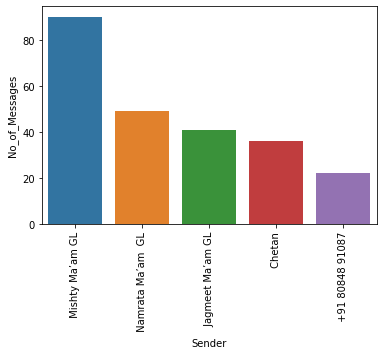

In [267]:
# Top 5 people who message the most
a=df_message.sort_values(by='No_of_Messages',ascending=False).head()
sns.barplot(x=a.Sender,y=a.No_of_Messages)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#As it is the official group of batch so it makes sense the most messages are sent by the faculties
#who are constantling making announcement and scheduling sessions.

### No of messages in each hour of day

In [268]:
df.Date.nunique()

80

In [269]:
#separating PM and AM Time
AM=[]
PM=[]
for i in df.Time:
    if'AM' in i:
        AM.append(i.split(' AM')[0].split(':')[0])
    else:
        PM.append(i.split(' PM')[0].split(':')[0])

In [270]:
#Converting into 24 hour format
for i in range(0,len(PM)):
    if PM[i]!='12':
        PM[i]=int(PM[i])+12
    else:
        PM[i]=int(PM[i])
AM=[int(i) for i in AM]

In [271]:
df['Hour']=AM+PM
df_hour=dict()
for i in df.Hour:
    df_hour[i]=df_hour.get(i,0)+1

In [283]:
df['Hour']=df.Time.apply(lambda x:int(x.split(' AM')[0].split(':')[0]) if 'AM' in x 
              else (int(x.split(' PM')[0].split(':')[0])+12) if  x.split(' PM')[0].split(':')[0]!=12  else int(x.split(' PM')[0].split(':')[0]))

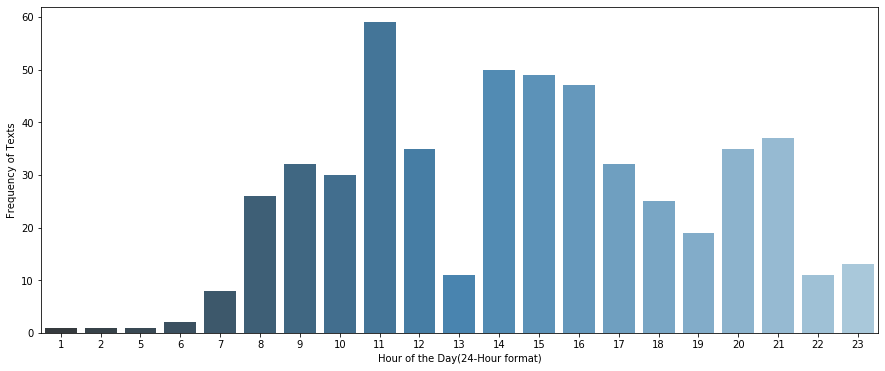

In [272]:
plt.figure(figsize=(15,6))
sns.barplot(x=list(df_hour.keys()),y=list(df_hour.values()),palette=("Blues_d"))
plt.xlabel('Hour of the Day(24-Hour format)')
plt.ylabel('Frequency of Texts')
plt.show()

In [164]:
#the frequency of messages exchanged is highest around 11am as class used to start around 10 am
# and issues related to recording or datasets uploaded on guru material(olympus) used to occur at this time.
# And most of the web sessions were also scheduled around 11am so most of the messages exchanges were regarding
#how to join web session

### Most active day of week

In [287]:
import datetime
def findDay(date): 
    day, month, year = (int(i) for i in str(date).split('/'))     
    time1 = datetime.date(year, month, day) 
    return time1.strftime("%a") 

In [288]:
df['Day']=df.Date.apply(lambda x:findDay(x))

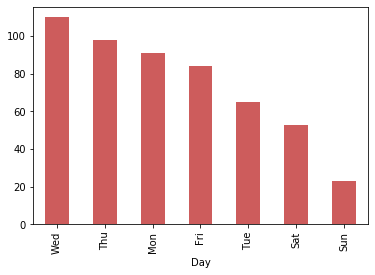

In [289]:
df.groupby(by='Day')['Day'].count().sort_values(ascending=False).plot.bar(color='indianred')
plt.show()

In [168]:
# On wednesday, we used to have peer sessions on wednesday after exam and most of the presentations also took place
#on wednesday so Wednesday has highest number of messages

### Heatmap to check no of messages sent at every hour of evey day

In [307]:
Msg_cnt=df[['Day','Hour','Message_count']].groupby(['Day','Hour']).count().unstack()

In [308]:
Msg_cnt.fillna(value=0,inplace=True)

In [309]:
Msg_cnt.columns=[[1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24]]

In [310]:
np.sort(df.Hour.unique())

array([ 1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24], dtype=int64)

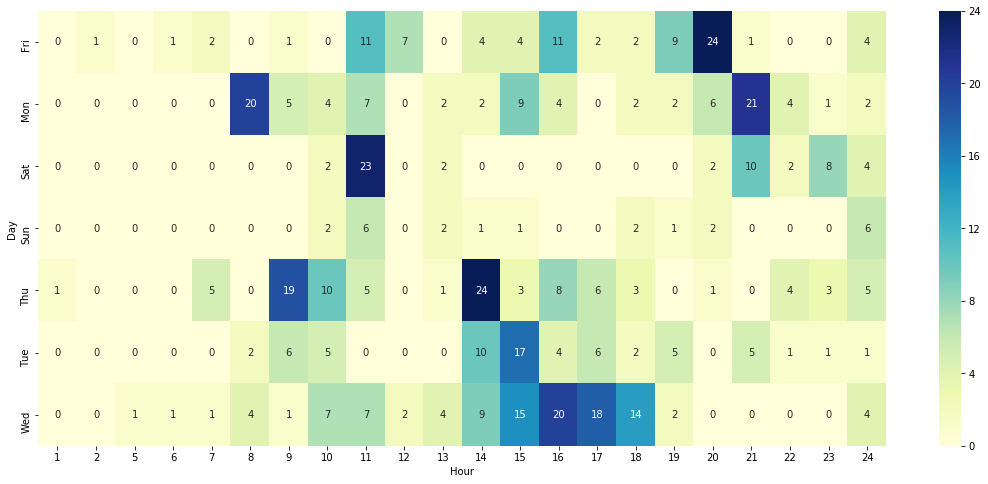

In [311]:
plt.figure(figsize=(19,8))
s=sns.heatmap(Msg_cnt,annot=True,cmap='YlGnBu')
plt.xlabel('Hour')
plt.show()

In [173]:
# Through graph we can check no of messages sent at any hour of any day
#here we can see mostly messages are exchanged between 9AM to 6PM and mostly during weekdays

### Count of emojis

In [312]:
#Finding frequency of all emojis

emojis=[j for i in df.message  for j in str(i) if j in emoji.UNICODE_EMOJI]
emodict=dict()
for i in emojis:
    emodict[i]=emodict.get(i,0)+1
    

In [313]:
emo=pd.DataFrame({'emoji':list(emodict.keys()),'Freq':list(emodict.values())})
emo=emo.sort_values(by='Freq',ascending=False).reset_index(drop=True)

In [314]:
uni=[]
for i in emo.emoji:
    #print((i).encode('unicode_escape').decode('utf8')[1:])
    uni.append((i).encode('unicode_escape').decode('utf8')[1:])

In [315]:
s=[]
for i in emo.emoji:
    s.append(emoji.demojize(i))

In [316]:
emo['short name']=s
emo['unicode']=uni

<script src="//ajax.googleapis.com/ajax/libs/jquery/1.12.4/jquery.min.js"></script>
<script src="js/jQueryEmoji.js"></script>

In [331]:
emo['short name']=emo['short name'].apply(lambda x: x.strip(':') )

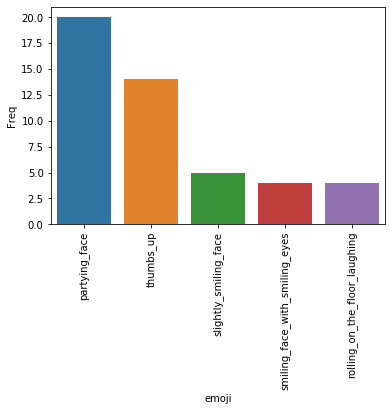

In [335]:
sns.barplot(x='emoji',y='Freq',data=emo.head())
plt.xticks(ticks=[0,1,2,3,4],labels=emo['short name'].head(),rotation=90)
plt.show()

In [336]:
#Clearly, Partying face and Thumbs up 👍 are the most frequently used emoji 
#Partying face cz of all festival greetings like Diwali, Christmas,New year and Holi
# And we can say students are pretty satisfied from the course and there quereies are resolved  and hence the thumbs up

### Avg Message length(No of characters)

In [337]:
##Function defined for cleaning text
import string
import re
from nltk.tokenize import word_tokenize

def clean_text(text):
    # lower text
    text = text.lower()

    # remove puncutation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # tokenize_text
    text = [word for word in word_tokenize(text)]

    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # remove empty tokens
    text = [t for t in text if len(t) > 0]

    # remove words with only one letter
    text = [t for t in text if len(t) > 1]

    # join all
    text = " ".join(text)
    return(text)

In [338]:
df.message=df.message.apply(lambda x:clean_text(x))

In [339]:
df['Message_length']=df.message.apply(lambda x:len(x))

In [340]:
a=df.groupby(by='Sender')['Message_length'].mean().sort_values(ascending=False).reset_index()

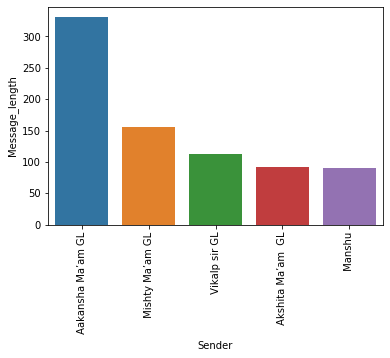

In [341]:
sns.barplot(x=a.Sender.head(),y=a.Message_length.head())
plt.xticks(rotation=90)
plt.show()

In [187]:
# The list of  highest avg length of message is dominated by Faculties and it makes sense as well as the group
#is used for important announcements. There is only  one student in top 5

## Avg word length  (no of words)

In [342]:
pd.set_option('display.max_colwidth', -1)

In [343]:
df['Word_count']=df.message.apply(lambda x:len(x.split()) )

In [344]:
b=df.groupby(by='Sender')['Word_count'].mean().sort_values(ascending=False).reset_index()

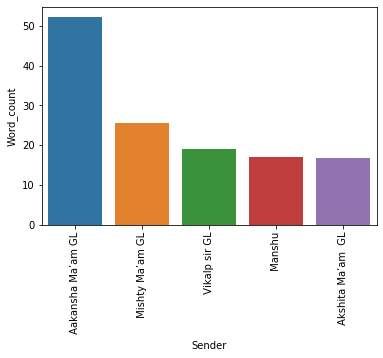

In [345]:
sns.barplot(x=b.Sender.head(),y=b.Word_count.head())
plt.xticks(rotation=90)
plt.show()

In [ ]:
## Since Aakansha Ma'am needs to provide detailed instructions for the online aptitide tests, the avg number of words used
#are high in comparison to other faculties

## Number of images shared

In [391]:
se=[]
for i in range(len(df.message)):
    if re.search('image omitted',df['message'][i]):
        se.append(df['Sender'][i])
            

In [392]:
img_cnt=dict()
for i in se:
    img_cnt[i]=img_cnt.get(i,0)+1


In [393]:
df['img_cnt']=df.Sender.apply(lambda x: img_cnt.get(x,0))

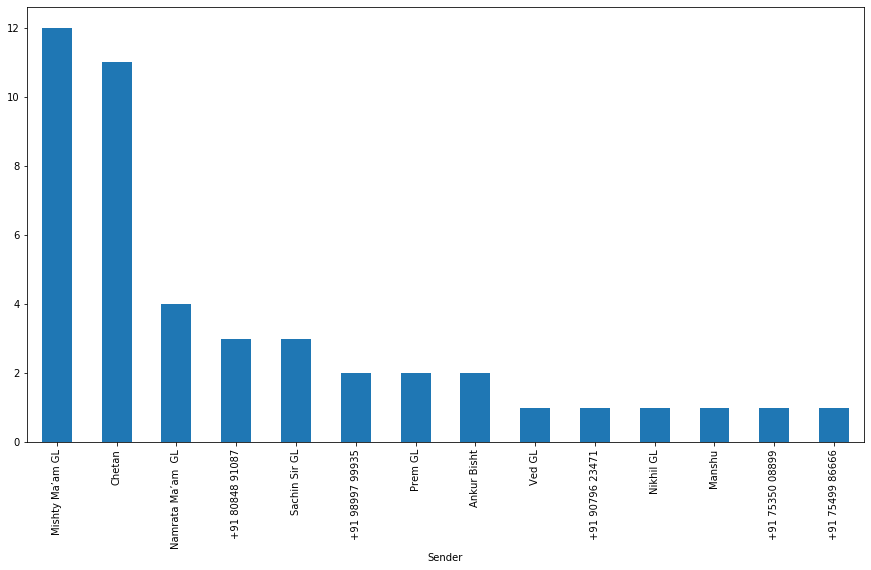

In [394]:
plt.figure(figsize=(15,8))
img=df.groupby('Sender')['img_cnt'].mean().sort_values(ascending=False)
img[img>0].plot.bar()
plt.show()

In [196]:
## Mishty ma'am has highest number of images shared as she keeps sharing interview material which is generally 
#images so this was expected but one the student (Chetan) has high no of images as well. On digging in ,it was
#found his team won Masquerade contest held during Christmas and he had shared photos of his group for the same.
 

## Filtering messages to eliminate images

In [396]:
f=[]
for i in df.message:
    a=re.search('image omitted',i)
    if a:
        continue
    else:
        f.append(i)

## Wordcloud

In [406]:
from nltk.corpus import stopwords
a=stopwords.words('English')

In [408]:
a.extend(['mam','maam','guys','kindly','hi','please','thank','This message was deleted','one'])

In [410]:
print(a)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

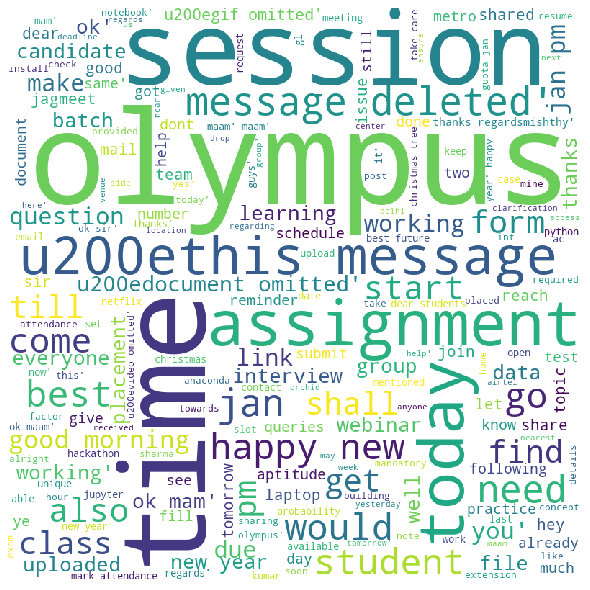

In [411]:
#Wordcloud
from wordcloud import WordCloud,STOPWORDS 
from nltk.corpus import stopwords as sp
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = a , 
                min_font_size = 10).generate(str(f))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
## On the basis of word cloud, most frequently used words came out to be olympus,assignment,session and time
#Olympus being an integral part of the edtech system of Great learning, no wonder it is the most used word
#Everything from assignment to test, webinar is  conducted on olympus

## Month wise message frequency

In [428]:
df['Month']=df.Date.apply(lambda x:'Oct' if '10' in x.split('/')[1] else 'Nov' if '11'==x.split('/')[1] 
              else 'Dec' if '12'==x.split('/')[1] else 'Jan' if '01'==x.split('/')[1]
             else 'Feb' if '02'==x.split('/')[1] else 'Mar')

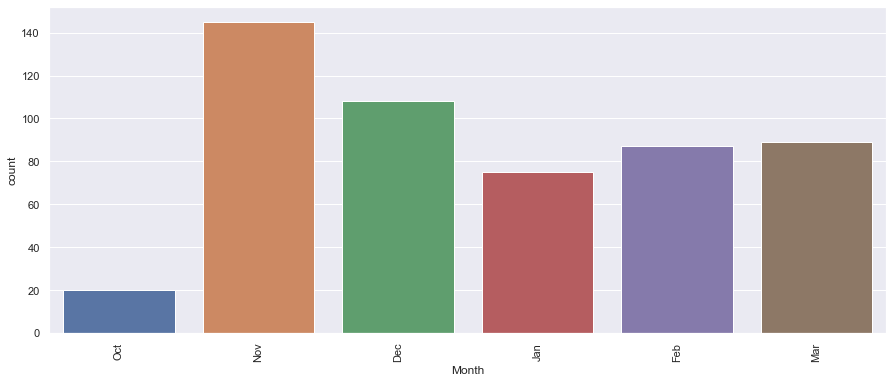

In [429]:
plt.figure(figsize=(15,6))
sns.set(style="darkgrid")
sns.countplot(df.Month)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Here we can see clear peak during Nov. Our batch started in november and everyone was full of doubts like
#location of centre,timings and usage of olympus. Hence the highest frequency is in November.
#Another inference here can be about March, although data is only till Mid march but freuqency is already equivalent to
#any other month, it can be attributed to recent riots in NCR and covid 19 as management has continuous making 
#announcements to ensure safety of students 